# Medical Cost Prediction Results

## Libraries and Configurations

In [1]:
import sys
from pathlib import Path

# path to project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

In [2]:
import src.utils as ut
import src.preprocess as pp
import src.config as cf
import src.train as tn
import src.evaluate as et

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

pd.options.display.max_columns = None

project path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250503 Personal Medical Costs
raw data path: C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250503 Personal Medical Costs\data\raw_data.csv
model path C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250503 Personal Medical Costs\models\model.pkl
results path C:\Users\Usuario\OneDrive\Documentos\Proyectos Personales\Data Science\Public Portfolio Data Science\250503 Personal Medical Costs\results


## Data Loading

In [3]:
raw_data = ut.load_data(cf.paths['data_raw'])
raw_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Splitting and Preprocessing

### Target - Feature and Train - Test Split

In [4]:
target = 'charges'
X = raw_data.drop(columns = target, axis = 1)
y = raw_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = cf.test_size, random_state = cf.random_state)

# hard copies for error analysis
X_train_plain = X_train.copy()
X_test_plain = X_test.copy()
y_train_plain = y_train.copy()
y_test_plain = y_test.copy()

### Pipeline Definition

In [5]:
# create preprocessing pipeline for feature variables
feature_preprocessing_pipeline = Pipeline(steps = [
    ('feature_selection', pp.FeatureSelector()),
    ('data_cleaning', pp.DataCleaning()),
    ('feature_engineering', pp.FeatureEngineering()),
    ('outlier_detection', pp.OutlierDetector()),
    ('missing_values', pp.MissingValuesHandler()),
    ('encoding', pp.CategoricalEncoder()),
    ('scaling', pp.Scaling())
])

### Feature Variable Preprocessing

In [6]:
X_train = feature_preprocessing_pipeline.fit_transform(X_train)

binary encoding applied to : sex
binary encoding applied to : smoker
one - hot encoding applied to : region


In [7]:
X_train.head()

,index,age,sex,bmi,children,smoker,age2,Logbmi,region_northeast,region_northwest,region_southeast,region_southwest
0,0.050112,0.478261,1.0,0.335929,0.2,0.0,0.338282,0.371650,0,1,0,0
1,0.550486,0.413043,0.0,0.727656,0.0,1.0,0.277041,0.722694,0,0,1,0
2,0.231862,0.695652,1.0,0.345174,0.0,0.0,0.576882,0.381663,0,0,0,1
3,0.720269,0.608696,1.0,0.286618,0.6,0.0,0.475080,0.316346,1,0,0,0
4,0.508601,0.065217,0.0,0.046715,0.2,0.0,0.031018,0.000000,0,0,0,1


In [8]:
X_test = feature_preprocessing_pipeline.fit_transform(X_test)

binary encoding applied to : sex
binary encoding applied to : smoker
one - hot encoding applied to : region


In [9]:
X_test.head()

,index,age,sex,bmi,children,smoker,age2,Logbmi,region_northeast,region_northwest,region_southeast,region_southwest
0,0.484598,0.673913,0.0,0.836378,0.4,0.0,0.550636,0.892631,0,0,1,0
1,0.235913,0.304348,1.0,0.663541,0.2,0.0,0.185578,0.764409,1,0,0,0
2,0.232156,0.195652,0.0,0.471625,0.0,1.0,0.107370,0.598503,0,0,0,1
3,0.108941,0.369565,1.0,0.236540,0.2,0.0,0.238865,0.346129,0,1,0,0
4,0.248685,0.913043,1.0,0.288601,0.0,0.0,0.868505,0.408026,0,0,1,0


## Modeling

### Linear Regression

#### Training

##### Model Fittting

In [10]:
# model fitting
start_time = time.time()

lr_results = tn.train_model(
    model_name = 'LinearRegression',
    X_train = X_train,
    y_train = y_train,
    mode = 'manual'
    )

end_time = time.time()

lr_train_time = end_time - start_time

# train score
lr_train_score = lr_results['cv_train_score']

# validation score
lr_val_score = lr_results['cv_val_score']

# best model
lr_best_model = lr_results['best_model']

# best parameters
lr_best_params = lr_results['best_params']

Log has been registered: Start training (regression) of model: LinearRegression
Log has been registered: Best Hyperparameters: {'fit_intercept': True}
Log has been registered: CV Train Score: {'mean': 0.7413376321574985, 'std': 0.008096364447844048}
Log has been registered: CV Validation Score: {'mean': 0.7204371178823994, 'std': 0.08269357769546067}
Log has been registered: Training complete for model: LinearRegression


##### Overfit Evaluation

In [11]:
lr_scores_df = pd.DataFrame(
    [lr_train_score, lr_val_score],
    index = ['Train Score', 'Validation Score']
)

lr_scores_df = lr_scores_df.style.format({
    'mean' : '{:.2%}',
    'std': '{:.2%}'
})

lr_scores_df

,mean,std
Train Score,74.13%,0.81%
Validation Score,72.04%,8.27%


##### Best Hyperparameters

In [12]:
pd.DataFrame(
    list(lr_best_params.items()),
    columns = ['Hyperparameter', 'Value']
)

,Hyperparameter,Value
0,fit_intercept,True


#### Testing

##### Predictions

In [13]:
# values predictions
start_time = time.time()
y_pred = lr_best_model.predict(X_test)
end_time = time.time()
lr_test_time = end_time - start_time

##### Regression Report

In [14]:
et.generate_regression_report(y_test, y_pred)

Regression report


,Value
Mean Absolute Error (MAE),4.487684e+05
Mean Squared Error (MSE),3.234876e+09
Root Mean Squared Error (RMSE),5.687597e+05
Mean Absolute Percentage Error (MAPE),5.525539e+01
R-squared (R2),7.884257e+01


Log has been registered: regression report generated


##### Residuals Plot

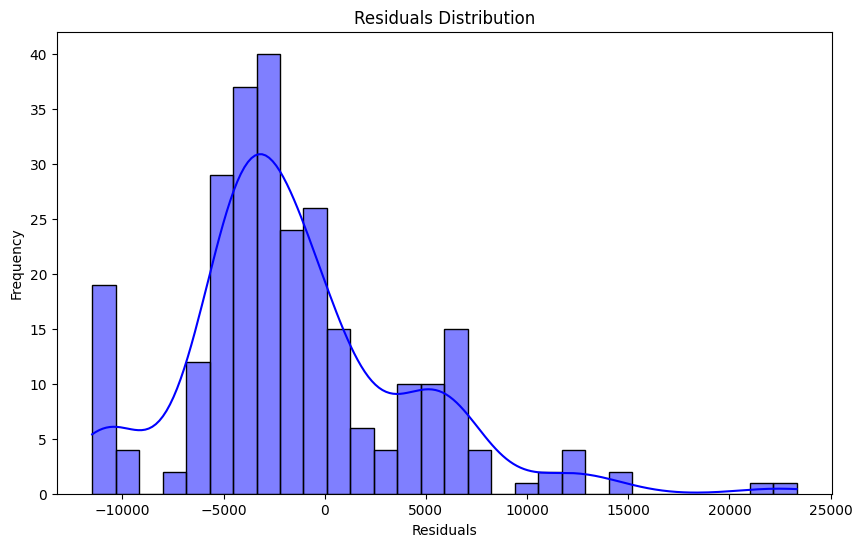

Log has been registered: residuals plot displayed


In [15]:
et.plot_residuals(y_test, y_pred)

##### Predictions Plot

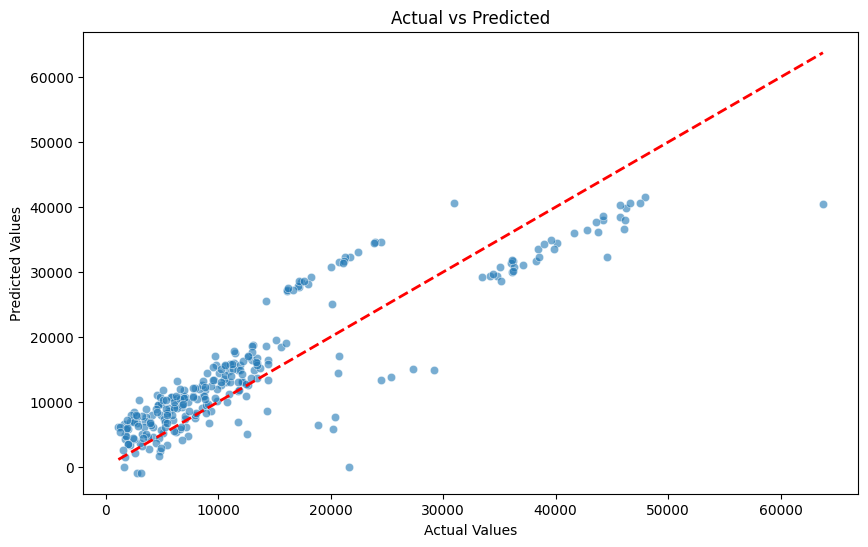

Log has been registered: actual vs predicted plot displayed


In [16]:
et.plot_predictions(y_test, y_pred)

##### Metrics Storage

In [17]:
lr_metrics = et.get_test_metrics(lr_best_model, X_test, y_test)

### Support Vector Regression

#### Training

##### Model Fittting

In [18]:
# model fitting
start_time = time.time()

svr_results = tn.train_model(
    model_name = 'SVR',
    X_train = X_train,
    y_train = y_train,
    mode = 'manual'
    )

end_time = time.time()

svr_train_time = end_time - start_time

# train score
svr_train_score = svr_results['cv_train_score']

# validation score
svr_val_score = svr_results['cv_val_score']

# best model
svr_best_model = svr_results['best_model']

# best parameters
svr_best_params = svr_results['best_params']

Log has been registered: Start training (regression) of model: SVR
Log has been registered: Best Hyperparameters: {'C': 10.1, 'kernel': 'poly', 'gamma': 1.1, 'degree': 5}
Log has been registered: CV Train Score: {'mean': 0.8148226334259675, 'std': 0.006490717512347075}
Log has been registered: CV Validation Score: {'mean': 0.7774592823488536, 'std': 0.06843285355621116}
Log has been registered: Training complete for model: SVR


##### Overfit Evaluation

In [19]:
svr_scores_df = pd.DataFrame(
    [svr_train_score, svr_val_score],
    index = ['Train Score', 'Validation Score']
)

svr_scores_df = svr_scores_df.style.format({
    'mean' : '{:.2%}',
    'std': '{:.2%}'
})

svr_scores_df

,mean,std
Train Score,81.48%,0.65%
Validation Score,77.75%,6.84%


##### Best Hyperparameters

In [20]:
pd.DataFrame(
    list(svr_best_params.items()),
    columns = ['Hyperparameter', 'Value']
)

,Hyperparameter,Value
0,C,10.1
1,kernel,poly
2,gamma,1.1
3,degree,5


#### Testing

##### Predictions

In [21]:
# values predictions
start_time = time.time()
y_pred = svr_best_model.predict(X_test)
end_time = time.time()
svr_test_time = end_time - start_time

##### Regression Report

In [22]:
et.generate_regression_report(y_test, y_pred)

Regression report


,Value
Mean Absolute Error (MAE),2.059070e+05
Mean Squared Error (MSE),1.956847e+09
Root Mean Squared Error (RMSE),4.423626e+05
Mean Absolute Percentage Error (MAPE),1.155674e+01
R-squared (R2),8.720141e+01


Log has been registered: regression report generated


##### Residuals Plot

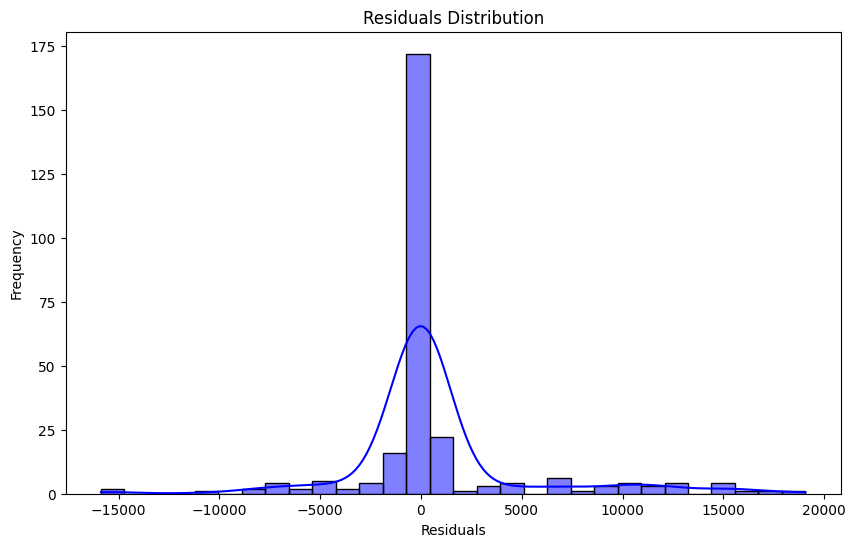

Log has been registered: residuals plot displayed


In [23]:
et.plot_residuals(y_test, y_pred)

##### Predictions Plot

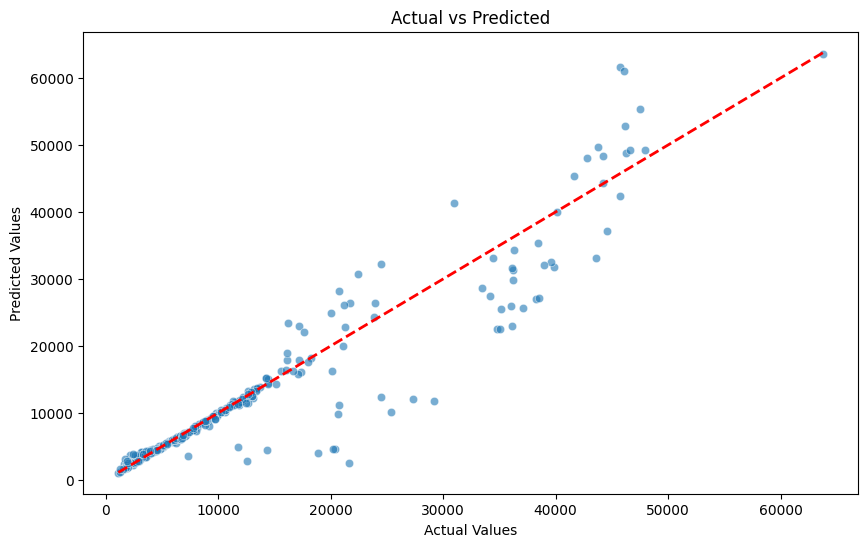

Log has been registered: actual vs predicted plot displayed


In [24]:
et.plot_predictions(y_test, y_pred)

##### Metrics Storage

In [25]:
svr_metrics = et.get_test_metrics(svr_best_model, X_test, y_test)

### Random Forest Regression

#### Training

##### Model Fittting

In [26]:
# model fitting
start_time = time.time()

rf_results = tn.train_model(
    model_name = 'RandomForest',
    X_train = X_train,
    y_train = y_train,
    mode = 'manual'
    )

end_time = time.time()

rf_train_time = end_time - start_time

# train score
rf_train_score = rf_results['cv_train_score']

# validation score
rf_val_score = rf_results['cv_val_score']

# best model
rf_best_model = rf_results['best_model']

# best parameters
rf_best_params = rf_results['best_params']

Log has been registered: Start training (regression) of model: RandomForest
Log has been registered: Best Hyperparameters: {'n_estimators': 364, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 12}
Log has been registered: CV Train Score: {'mean': 0.8726373845264188, 'std': 0.005193222340837699}
Log has been registered: CV Validation Score: {'mean': 0.8341141487323049, 'std': 0.061998680102573006}
Log has been registered: Training complete for model: RandomForest


##### Overfit Evaluation

In [27]:
rf_scores_df = pd.DataFrame(
    [rf_train_score, rf_val_score],
    index = ['Train Score', 'Validation Score']
)

rf_scores_df = rf_scores_df.style.format({
    'mean' : '{:.2%}',
    'std': '{:.2%}'
})

rf_scores_df

,mean,std
Train Score,87.26%,0.52%
Validation Score,83.41%,6.20%


##### Best Hyperparameters

In [28]:
pd.DataFrame(
    list(rf_best_params.items()),
    columns = ['Hyperparameter', 'Value']
)

,Hyperparameter,Value
0,n_estimators,364
1,max_depth,5
2,min_samples_split,4
3,min_samples_leaf,12


#### Testing

##### Predictions

In [29]:
# values predictions
start_time = time.time()
y_pred = rf_best_model.predict(X_test)
end_time = time.time()
rf_test_time = end_time - start_time

##### Regression Report

In [30]:
et.generate_regression_report(y_test, y_pred)

Regression report


,Value
Mean Absolute Error (MAE),2.327250e+05
Mean Squared Error (MSE),1.411542e+09
Root Mean Squared Error (RMSE),3.757049e+05
Mean Absolute Percentage Error (MAPE),2.850876e+01
R-squared (R2),9.076793e+01


Log has been registered: regression report generated


##### Residuals Plot

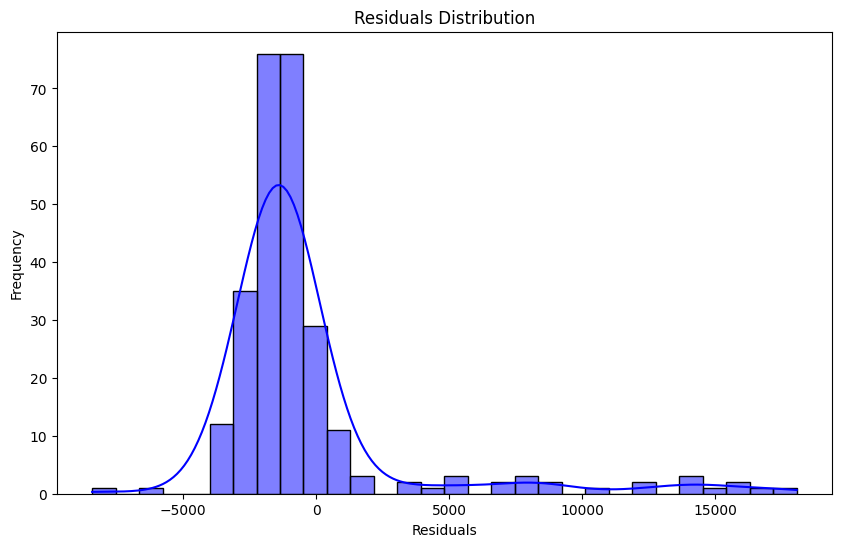

Log has been registered: residuals plot displayed


In [31]:
et.plot_residuals(y_test, y_pred)

##### Predictions Plot

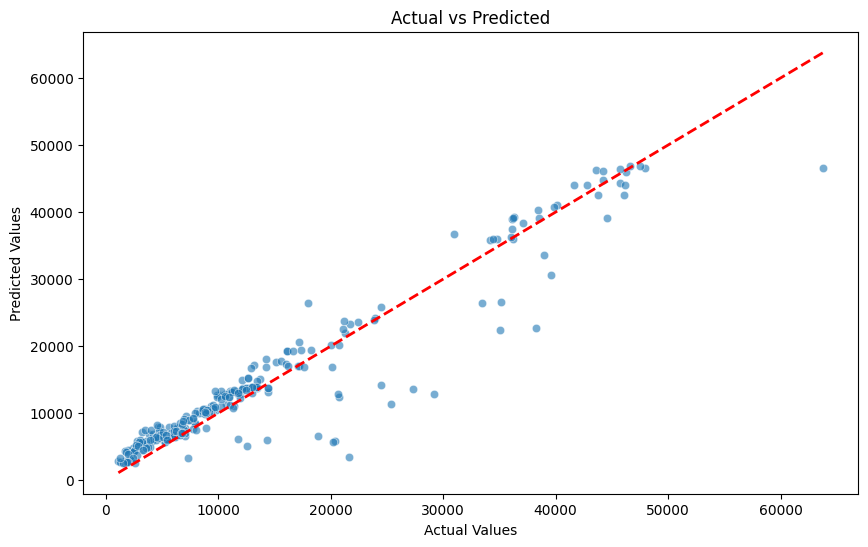

Log has been registered: actual vs predicted plot displayed


In [32]:
et.plot_predictions(y_test, y_pred)

##### Metrics Storage

In [44]:
rf_metrics = et.get_test_metrics(rf_best_model, X_test, y_test)

### Gradient Boosting Regression

#### Training

##### Model Fittting

In [34]:
# model fitting
start_time = time.time()

gb_results = tn.train_model(
    model_name = 'GradientBoosting',
    X_train = X_train,
    y_train = y_train,
    mode = 'manual'
    )

end_time = time.time()

gb_train_time = end_time - start_time

# train score
gb_train_score = gb_results['cv_train_score']

# validation score
gb_val_score = gb_results['cv_val_score']

# best model
gb_best_model = gb_results['best_model']

# best parameters
gb_best_params = gb_results['best_params']

Log has been registered: Start training (regression) of model: GradientBoosting
Log has been registered: Best Hyperparameters: {'learning_rate': 0.16, 'n_estimators': 103, 'max_depth': 3, 'subsample': 0.9}
Log has been registered: CV Train Score: {'mean': 0.9359235216734177, 'std': 0.0022287887318039015}
Log has been registered: CV Validation Score: {'mean': 0.8169955923109107, 'std': 0.06162100469493013}
Log has been registered: Training complete for model: GradientBoosting


##### Overfit Evaluation

In [36]:
gb_scores_df = pd.DataFrame(
    [gb_train_score, gb_val_score],
    index = ['Train Score', 'Validation Score']
)

gb_scores_df = gb_scores_df.style.format({
    'mean' : '{:.2%}',
    'std': '{:.2%}'
})

gb_scores_df

,mean,std
Train Score,93.59%,0.22%
Validation Score,81.70%,6.16%


##### Best Hyperparameters

In [38]:
pd.DataFrame(
    list(gb_best_params.items()),
    columns = ['Hyperparameter', 'Value']
)

,Hyperparameter,Value
0,learning_rate,0.16
1,n_estimators,103.00
2,max_depth,3.00
3,subsample,0.90


#### Testing

##### Predictions

In [39]:
# values predictions
start_time = time.time()
y_pred = gb_best_model.predict(X_test)
end_time = time.time()
gb_test_time = end_time - start_time

##### Regression Report

In [40]:
et.generate_regression_report(y_test, y_pred)

Regression report


,Value
Mean Absolute Error (MAE),3.818571e+05
Mean Squared Error (MSE),2.727230e+09
Root Mean Squared Error (RMSE),5.222289e+05
Mean Absolute Percentage Error (MAPE),5.316030e+01
R-squared (R2),8.216279e+01


Log has been registered: regression report generated


##### Residuals Plot

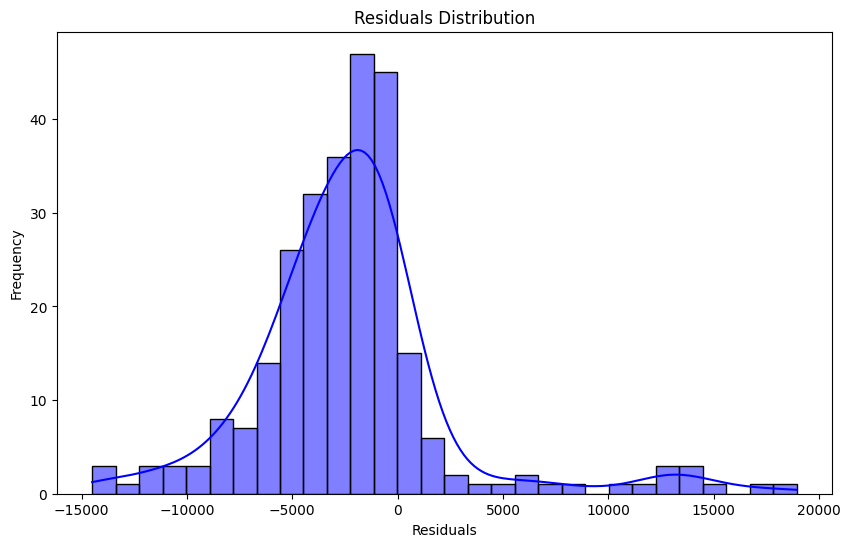

Log has been registered: residuals plot displayed


In [41]:
et.plot_residuals(y_test, y_pred)

##### Predictions Plot

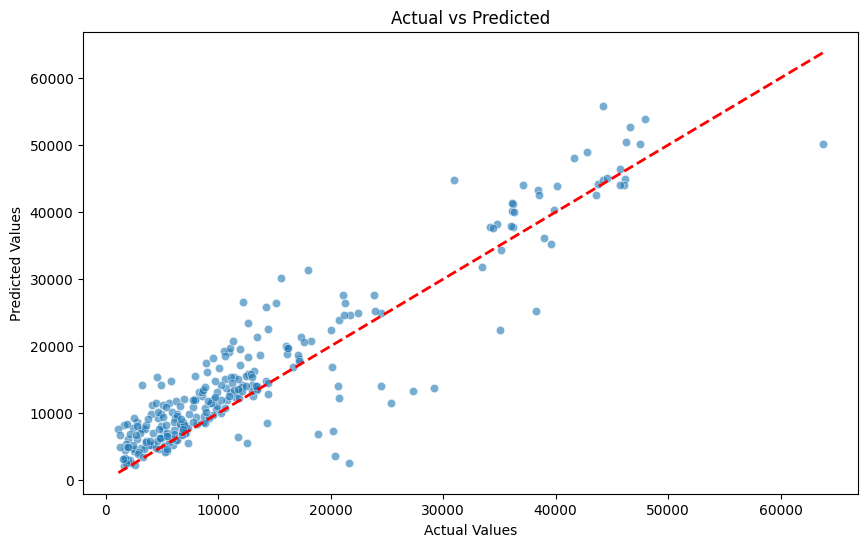

Log has been registered: actual vs predicted plot displayed


In [42]:
et.plot_predictions(y_test, y_pred)

##### Metrics Storage

In [45]:
gb_metrics = et.get_test_metrics(gb_best_model, X_test, y_test)

## Model Benchmarking

### Key Metrics Comparison

In [48]:
results_df = pd.DataFrame([lr_metrics, svr_metrics, rf_metrics, gb_metrics], index = ['Linear Regression', 'Support Vector Regression', 'Random Forest', 'Gradient Boosting'])

results_df.style.format('{:.2%}')

,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,r2_score
Linear Regression,381857.05%,2727230283.69%,522228.90%,53.16%,82.16%
Support Vector Regression,205906.97%,1956847066.57%,442362.64%,11.56%,87.20%
Random Forest,232725.05%,1411541840.85%,375704.92%,28.51%,90.77%
Gradient Boosting,381857.05%,2727230283.69%,522228.90%,53.16%,82.16%


### Train Time

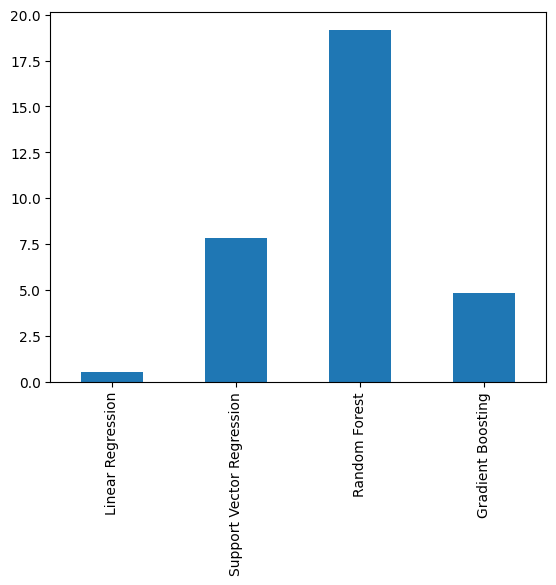

In [49]:
train_time_df = pd.DataFrame([lr_train_time, svr_train_time, rf_train_time, gb_train_time], index = ['Linear Regression', 'Support Vector Regression', 'Random Forest', 'Gradient Boosting'])
train_time_df.plot(kind = 'bar', legend = False)
plt.show()

### Prediction Time

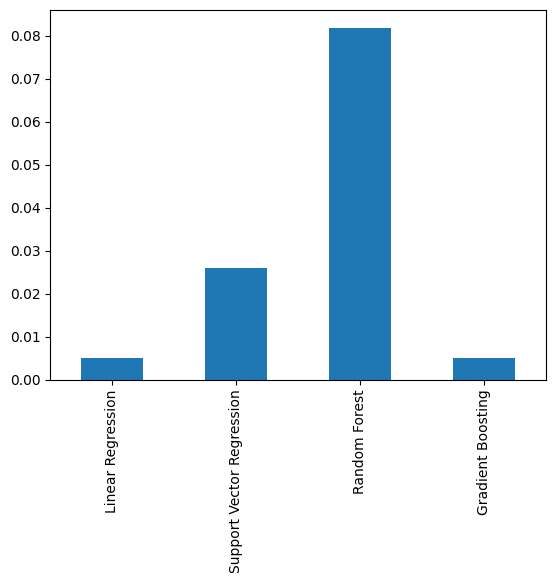

In [50]:
test_time_df = pd.DataFrame([lr_test_time, svr_test_time, rf_test_time, gb_test_time], index = ['Linear Regression', 'Support Vector Regression', 'Random Forest', 'Gradient Boosting'])
test_time_df.plot(kind = 'bar', legend = False)
plt.show()